<img src="https://raw.githubusercontent.com/earthdaily/Images/main/Corporate/EarthDaily.png" width="20%" alt="EarthDaily Analytics">

# Analyzing the Impact of the 2021 Dixie Fire Using Earth Mosaics
__________________
<a href="https://earthdaily.com/contact/">Give Feedback</a> | <a href="https://github.com/earthdaily">Bug report</a>

**Tags:** #EDS, #EarthMosaics, #wildfires, #burnindex

**Authors**: EarthDaily Analytics

**Last update:** 2024-11-07 (Created: 2024-11-05)

**References:**
- [EarthDaily package](https://github.com/earthdaily/earthdaily-python-client)
- [Earth Data Store documentation](https://earthdaily.github.io/EDA-Documentation/)
- [Xarray as multi-dimensional object](https://docs.xarray.dev/en/stable/)
- [Spyndex spectral indices library](https://github.com/awesome-spectral-indices/spyndex)

## Introduction
In this notebook, we perform an analysis of the area affected by the [2021 Dixie Fire in Northern California](https://en.wikipedia.org/wiki/Dixie_Fire). The Dixie Fire was an enormous wildfire that burned over 963,309 acres across multiple counties and was the largest single-source wildfire in California's recorded history.

## Objectives 

By the end of this analysis, we will have quantified the total burned area and generated geospatial data that can aid in understanding the fire's impact.

- **Data Acquisition**: Query sub-areas of pre-fire and post-fire mosaics using specific mosaic IDs.
- **Visualization**: Visualize the burned area by processing and comparing pre-event and post-event imagery.
- **Burn Extent Mapping**: Detect newly burned areas by analyzing the difference in BAI and NBR between pre- and post-fire images.
- **Area Quantification**: Calculate the total area affected by the fires in hectares.
- **Data Export**: Save intermediate data as GeoTIFFs for visualization in GIS software such as QGIS.
- **Adaptability**: Provide a workflow that can be adapted for other events requiring pre- and post-state analysis, such as floods, deforestation, or urban development.

## Data Description

We utilize satellite imagery from the EarthDataStore, specifically the **AI-Ready Mosaics Collection**, generated using the [EarthDaily EarthMosaics](https://earthdaily.com/product-service/earthmosaics/) service using Sentinel-2 imagery. The imagery includes the **NIR0.8**, **RED**, and **SWIR2.2** bands, essential for computing Burned Area Index (BAI) and Normalized Burn Ratio (NBR). The datasets are:

- **Pre-Fire Image**: Captured before the fires in May 2021.
- **Post-Fire Image**: Captured after the fires in September 2021.

These images allow us to perform a comparative analysis to identify total extent of the burned area due to the fires.

## Methodology

### Burned Area Index (BAI)

The [BAI](https://digital.csic.es/bitstream/10261/6426/1/Martin_Isabel_Serie_Geografica.pdf) is used to identify and assess burned areas after a wildfire, specifically using the **Red (665nm)** and **Near-Infrared (842nm)** bands as they are sensitive to changes in chlorophyll content in burned and healthy vegetation respectively. 

### Normalized Burn Ratio (NBR)

The [NBR](https://pubs.usgs.gov/publication/ofr0211) is also used to identify and assess burned areas, however makes use of the **Short-Wave Infrared (2190nm)** and **Near-Infrared (842nm)** bands. 

### Burned Area Detection Procedure

1. **Data Discovery and Image Loading**: Retreive pre- and post-fire satellite images metadata using the [`EarthDaily Python Client`](https://github.com/earthdaily/earthdaily-python-client/tree/main) and load using the [`stac_load`](https://odc-stac.readthedocs.io/en/latest/_api/odc.stac.load.html) function.
2. **Index Calculation and Difference Computation**: Compute the BAI and NBR for both images to highlight burned areas and calculate the difference between the post-fire and pre-fire BAI and NBR to identify new burned areas caused by the wildfires.
3. **Thresholding, Polygon Creation, and Area Calculation**: Apply a threshold (e.g., the 90th percentile) to the difference image to create a binary mask of burned areas, convert the binary mask to polygons using the [`rasterio.features.shapes`](https://rasterio.readthedocs.io/en/latest/api/rasterio.features.html#rasterio.features.shapes) function, and compute the area of each polygon to quantify the total affected area.

## Environment Setup

We start by setting up the environment and loading the necessary libraries, including [Dask](https://www.dask.org/) for parallel computing and geospatial libraries like [GeoPandas](https://geopandas.org/en/stable/docs/reference.html) and [Rasterio](https://rasterio.readthedocs.io/en/stable/).

We then:

- **Load Environment Variables**: Access API keys and other configurations.
- **Initialize the Dask Client**: Set up Dask for efficient data processing.
- **Authenticate and Initialize the Earth Data Store Client**: Connect to the data source for querying and retrieving satellite imagery.
- **Declare Global Variables**: Such as the input Collection, a list of Bands, output Resolution, Bounding Box to clip to, and the corresponding STAC Item IDs for the input EarthMosaic datasets.

### Import dependencies

In [1]:
from earthdaily import EarthDataStore

In [2]:
import os
import requests
import rioxarray

import geopandas as gpd
import numpy as np
import xarray as xr

from rasterio.features import shapes
from shapely.geometry import shape
from dotenv import load_dotenv
from odc.stac import configure_rio, stac_load

import matplotlib.pyplot as plt

In [3]:
import dask.distributed

### Authentication
Loading in environment variables, please update the associated [`EDS.env`](EDS.env), which can be downloaded from the [EarthDaily Account Management page](https://console.earthdaily.com/account).

In [4]:
load_dotenv("EDS.env")

True

> _**Note:**_ To gain access to the Earth Data Store data used in this example, please [create an EarthDaily account](https://console.earthdaily.com/mosaics/signup)

> _**Note:**_ To gain access to the Earth Data Store data used in this example, please [create an EarthDaily account](https://console.earthdaily.com/mosaics/signup)

Establishing a connection to the Earth Data Store:

In [5]:
eds = EarthDataStore()

### Dask Client
Here we take advantage of the concurrent processing capabilities of the [Dask Distributed API](https://distributed.dask.org/en/stable/) for larger raster workloads:

In [6]:
client = dask.distributed.Client()
configure_rio(cloud_defaults=True, aws={"aws_unsigned": True}, client=client)

### Declare Variables
Query parameters for the specific item, including STAC Collection and a list of bands:

In [7]:
COLLECTION = "ai-ready-mosaics-sample"
BANDS = ("red", "nir08", "swir22")
RESOLUTION=10.

Dictionary to store item IDs for pre- and post-fire

In [8]:
item_dict = {
    "PRE": { "item_id": "EDA_Mosaic_M_L2A_EM_Mosaic_ZeiuG"},# PRE FIRE
    "POST": {"item_id": "EDA_Mosaic_M_L2A_EM_Mosaic_GBV5d"}# POST FIRE
}

_**Note:** The following function replaces each STAC Item's default href with an alternate presigned URL. This allows for access to the data directly without the need for an AWS account._

In [9]:
def replace_alternate_href(item):
    for asset in item.assets:
        alt_href = item.assets[asset].extra_fields['alternate']['download']['href']
        item.assets[asset].href = alt_href
    return item

**_Note: Working with Large Mosaic Datasets_**

Satellite image mosaics covering vast regions like the Dixie Fire area are quite large and can be computationally intensive to process. To optimize performance:

- **Define an Area of Interest (AOI)**: Load a specific sub-area defined by an AOI to reduce processing time and resource usage.
- **Full Mosaic Option**: If a comprehensive analysis is needed, you can process the entire mosaic by excluding the bounding box (bbox) parameter from your queries. Keep in mind that this will significantly increase computation time.

By focusing on a defined AOI, we ensure that the analysis is efficient and manageable while still capturing the essential data related to the event. Uncomment the larger extent bounding box in the cell below to expand the study area of this notebook. 

In [10]:
bbox = (-121.32559295351282,40.09770246706907,-120.86738632168885,40.386534879495315)
# bbox = (-122.08464751,   39.36533575, -120.56137851,   40.74021473) # Larger extent

_Conversely, read in an input GeoJSON or Shapefile using the geopandas library to retrieve its bounding box extent_

## Loading Satellite Data and Calculating Burn Indices

Below we will iterate over each Item ID corresponding to a **PRE** and **POST** fire Mosaic. For each item we:

* Retrieve the corresponding EarthMosaic items through an Earth Data Store search by passing a Collection and Item ID
* Use [`stac_load`](https://odc-stac.readthedocs.io/en/latest/_api/odc.stac.load.html) to retrieve an [`xarray Dataset`](https://docs.xarray.dev/en/stable/), which includes: 
    - **Band Selection**: We focus on key spectral bands—near-infrared (nir08), red, and short-wave infrared (swir22)—which are later used for calculating Burned Area Index (BAI) and Normalized Burn Ratio (NBR)
    - **CRS and Resolution**: We reproject the data to **EPSG:3857** to work with a 10-meter spatial resolution.
* Calculate BAI and NBR, which utilizes the [`spyndex`](https://spyndex.readthedocs.io/en/latest/) library for efficient calculation of spectral indices.
    * Note in this example we take advantage of the [`EarthDailyAccessorDataset.add_indces()`](https://earthdaily.github.io/earthdaily-python-client/earthdaily.accessor.html#earthdaily.accessor.EarthDailyAccessorDataset) utility, which uses spyndex.

_**Note**: Spyndex supports a wide range of indices. Feel free to experiment with other indices like the Normalized Burn Ratio (NBR) or the Difference Vegetation Index (DVI) to compare results._

In [11]:
for post_or_pre, data_dict in item_dict.items():
    print(f"Processing {post_or_pre}-fire imagery")
    # Search items
    item = eds.search(
        collections=COLLECTION,
        ids=[data_dict["item_id"]],
    )[0]
    # Replace alternate HREF links
    item = replace_alternate_href(item)
    # Setting item in dict
    item_dict[post_or_pre]["item"]=item
    # Loading xarray dataset
    dataset = stac_load(
        [item],
        bands=BANDS,
        crs="epsg:3857", 
        resolution=RESOLUTION, 
        chunks={'x':2048, 'y': 2048},  # here we use Dask to lazy load the data
        groupby="id",
        bbox=bbox,
    )
    print("Returned dataset")
    # Calculating BAI using Spyndex
    dataset=dataset.ed.add_indices(
        ['BAI', 'NBR'], 
        R=dataset['red'], 
        N=dataset['nir08'], 
        S2=dataset['swir22']
    )
    print("Calculated BAI and NBR")
    # Passing the xr Dataset as a value in the item_dict
    item_dict[post_or_pre]["dataset"]=dataset

Processing PRE-fire imagery
Returned dataset
Calculated BAI and NBR
Processing POST-fire imagery
Returned dataset
Calculated BAI and NBR


### Plot Output Imagery and Spectral Indices
Below, for each image we plot a false-color RGB composite **(SWIR,NIR,RED)** alongside the corresponding Burned Area Index and Normalized Burn Ratio:

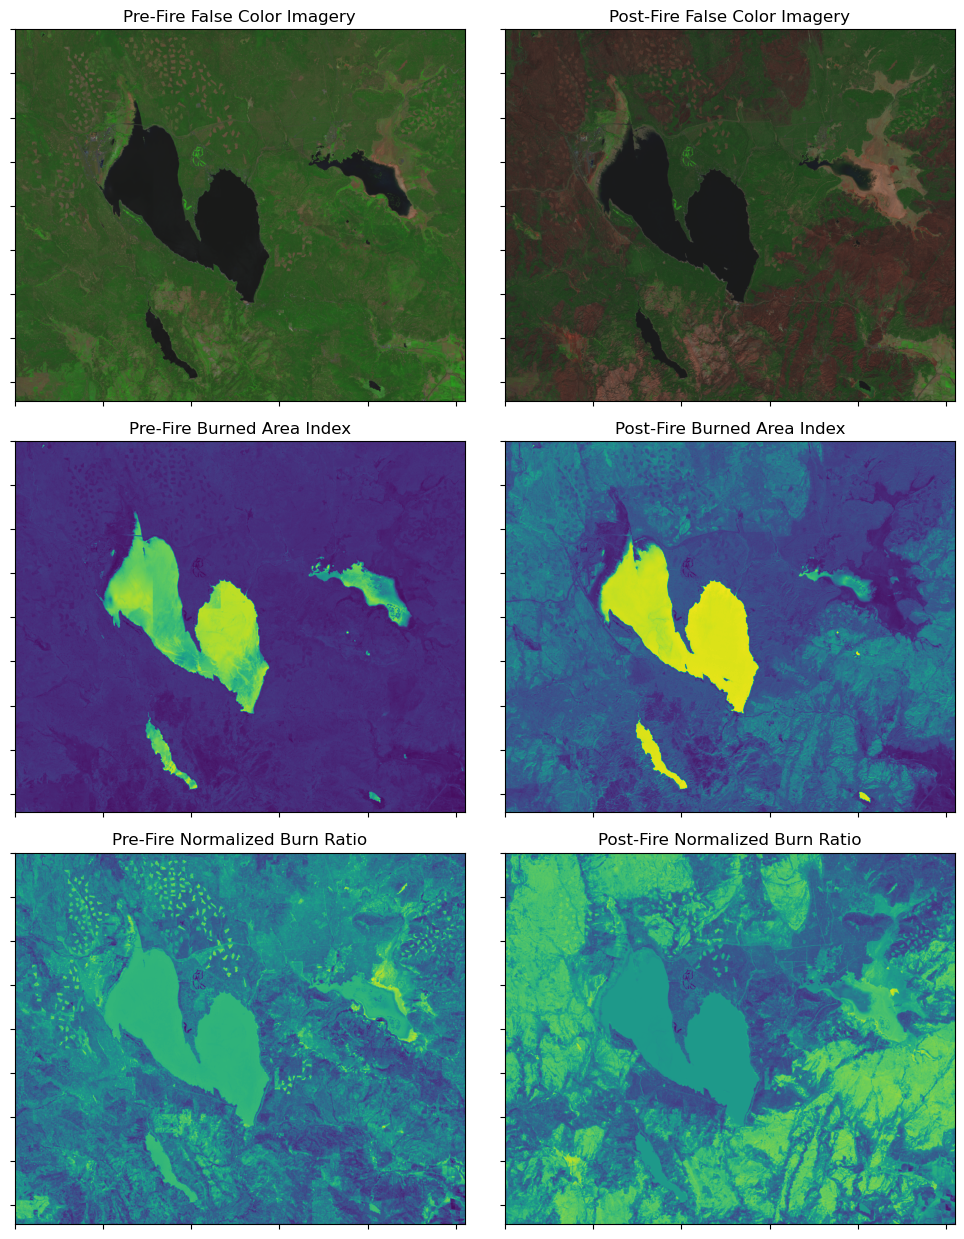

In [12]:
fig, ax = plt.subplots(
    figsize=(10,12.5), nrows=3, ncols=2
)

pre = item_dict['PRE']['dataset'].isel(time=0)
post = item_dict['POST']['dataset'].isel(time=0)

pre_arr = np.stack(
    [pre['swir22'], pre['nir08'], pre['red']], 
    axis=-1
)

post_arr = np.stack(
    [post['swir22'], post['nir08'], post['red']],
    axis=-1
)

ax[0][0].imshow(((pre_arr/10000)*255).astype('uint8'))
ax[0][0].set_title("Pre-Fire False Color Imagery")
ax[0][0].set_yticklabels([])
ax[0][0].set_xticklabels([])

ax[0][1].imshow(((post_arr/10000)*255).astype('uint8'))
ax[0][1].set_title("Post-Fire False Color Imagery")
ax[0][1].set_yticklabels([])
ax[0][1].set_xticklabels([])


ax[1][0].imshow(pre['BAI'])
ax[1][0].set_title("Pre-Fire Burned Area Index")
ax[1][0].set_yticklabels([])
ax[1][0].set_xticklabels([])

ax[1][1].imshow(post['BAI'])
ax[1][1].set_title("Post-Fire Burned Area Index")
ax[1][1].set_yticklabels([])
ax[1][1].set_xticklabels([])

ax[2][0].imshow(pre['NBR'], cmap="viridis_r")
ax[2][0].set_title("Pre-Fire Normalized Burn Ratio")
ax[2][0].set_yticklabels([])
ax[2][0].set_xticklabels([])

ax[2][1].imshow(post['NBR'], cmap="viridis_r")
ax[2][1].set_title("Post-Fire Normalized Burn Ratio")
ax[2][1].set_yticklabels([])
ax[2][1].set_xticklabels([])

plt.tight_layout()
del pre_arr, post_arr

## Calculate the Burned Area

Analyzing the difference in BAI and NBR values enables:

- **Change Detection**: Areas with substantial differences indicate potential burned regions.
- **Quantification**: This allows us to estimate the extent of the area affected by the fire.

This comparative analysis is crucial for assessing the fire's impact on the landscape.

### Pre- and Post-Fire Index Comparison
First we subtract the PRE and POST fire burn indices to calculate a difference:

In [13]:
bai_diff = xr.concat(
    [item_dict['PRE']['dataset']['BAI'], item_dict['POST']['dataset']['BAI']],
    dim='time'
).diff(dim='time')

nbr_diff = xr.concat(
    [item_dict['PRE']['dataset']['NBR'], item_dict['POST']['dataset']['NBR']],
    dim='time'
).diff(dim='time')
nbr_diff

<xarray.DataArray 'NBR' (time: 1, y: 4213, x: 5102)> Size: 86MB
dask.array<sub, shape=(1, 4213, 5102), dtype=float32, chunksize=(1, 2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 34kB 4.922e+06 4.922e+06 ... 4.88e+06 4.88e+06
  * x            (x) float64 41kB -1.351e+07 -1.351e+07 ... -1.345e+07
    spatial_ref  int32 4B 3857
  * time         (time) datetime64[ns] 8B 2021-09-29T18:45:37.906583

### Plot Difference in Burn Indices

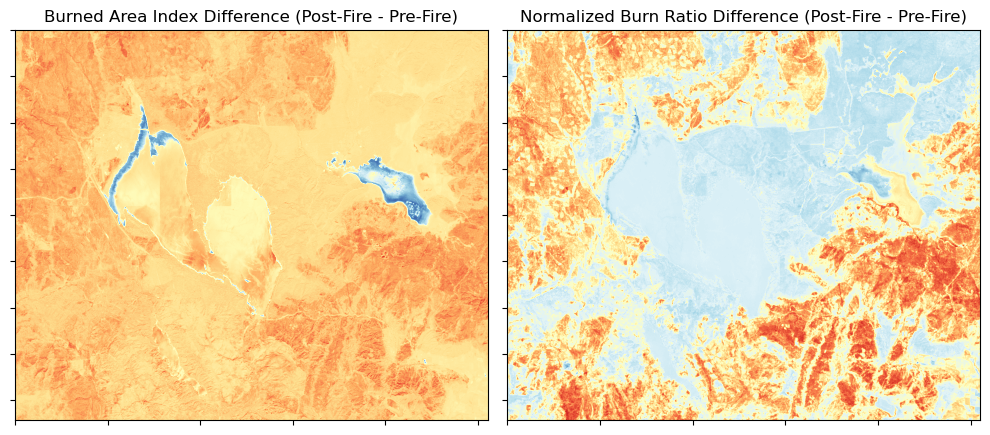

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
# bai_diff.plot(cmap='RdYlBu_r', ax=ax[0])
ax[0].imshow(bai_diff[0], cmap='RdYlBu_r')
ax[0].set_title("Burned Area Index Difference (Post-Fire - Pre-Fire)")
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
# nbr_diff.plot(cmap='RdYlBu', ax=ax[1])
ax[1].imshow(nbr_diff[0], cmap='RdYlBu')
ax[1].set_title("Normalized Burn Ratio Difference (Post-Fire - Pre-Fire)")
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
plt.tight_layout()

### Exporting Data for GIS Visualization

To facilitate visualization and further spatial analysis:

- **GeoTIFF Export**: Save the xarray dataset as a GeoTIFF file.
- **GIS Compatibility**: The GeoTIFF can be imported into GIS software like QGIS, allowing for interactive exploration and overlay with other geospatial datasets.

By exporting the data, we bridge the gap between data processing and practical application in GIS platforms.

In [15]:
bai_diff.rio.to_raster("BAI_diff.tif")

In [16]:
bai_diff = rioxarray.open_rasterio("BAI_diff.tif")
bai_diff

<xarray.DataArray (band: 1, y: 4213, x: 5102)> Size: 86MB
[21494726 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 41kB -1.351e+07 -1.351e+07 ... -1.345e+07
  * y            (y) float64 34kB 4.922e+06 4.922e+06 ... 4.88e+06 4.88e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      BAI

### Extracting Burned Area Polygons
To visualize and quantify the burned areas:

- **Thresholding**: Apply a threshold to the BAI difference image to isolate significant changes.
- **Polygon Generation**: Use the [`rasterio.features.shapes`](https://rasterio.readthedocs.io/en/latest/api/rasterio.features.html#rasterio.features.shapes) module to vectorize the boundaries of burned regions.
- **Export to GeoJSON**: Save the polygons as a GeoJSON file for use in GIS applications.

This step transforms raster data into vector formats suitable for spatial analysis and mapping.

#### Threshold Selection

Choosing the right threshold is crucial for accurately identifying burned areas.

In this cell, we explore different threshold values using [`np.nanpercentile`](https://numpy.org/doc/stable/reference/generated/numpy.nanpercentile.html) to retrieve the 90th and 95th percentile values for BAI difference between pre- and post-fire. We then create a _binary mask_ array where 1=above the threshold and 0=below the threshold. Note that as the percentile decreses, more pixels are classified as burned:

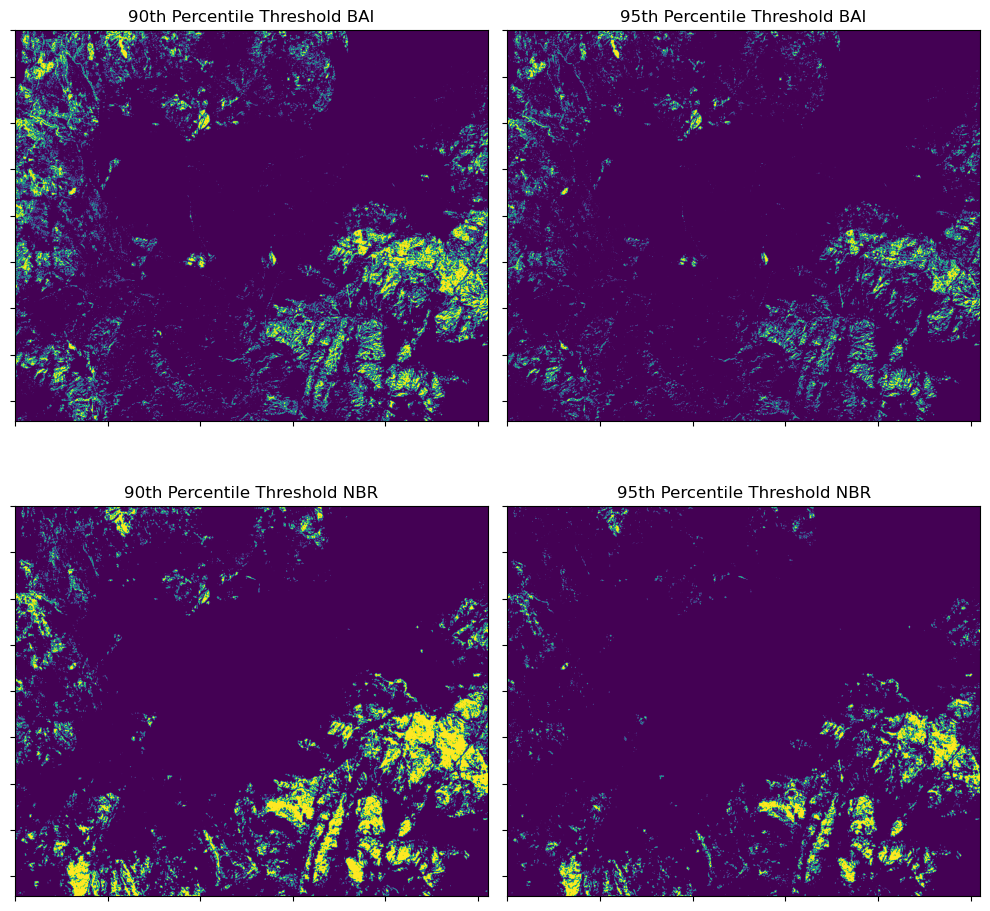

In [17]:
fig, ax = plt.subplots(figsize=(10,10), nrows=2, ncols=2)
# Apply a threshold to identify significant differences
bai_threshold_value_90 = np.nanpercentile(bai_diff, 90)
bai_threshold_value_95 = np.nanpercentile(bai_diff, 95)

bai_diff_msk_90 = (bai_diff>bai_threshold_value_90).astype('uint8')
bai_diff_msk_95 = (bai_diff>bai_threshold_value_95).astype('uint8')

nbr_threshold_value_90 = np.nanpercentile(nbr_diff, 10)
nbr_threshold_value_95 = np.nanpercentile(nbr_diff, 5)

nbr_diff_msk_90 = (nbr_diff<nbr_threshold_value_90).astype('uint8')
nbr_diff_msk_95 = (nbr_diff<nbr_threshold_value_95).astype('uint8')

ax[0][0].imshow(bai_diff_msk_90[0])
ax[0][0].set_title("90th Percentile Threshold BAI")
ax[0][0].set_yticklabels([])
ax[0][0].set_xticklabels([])

ax[0][1].imshow(bai_diff_msk_95[0])
ax[0][1].set_title("95th Percentile Threshold BAI")
ax[0][1].set_yticklabels([])
ax[0][1].set_xticklabels([])

ax[1][0].imshow(nbr_diff_msk_90[0])
ax[1][0].set_title("90th Percentile Threshold NBR")
ax[1][0].set_yticklabels([])
ax[1][0].set_xticklabels([])

ax[1][1].imshow(nbr_diff_msk_95[0])
ax[1][1].set_title("95th Percentile Threshold NBR")
ax[1][1].set_yticklabels([])
ax[1][1].set_xticklabels([])

plt.tight_layout()

#### Vectorization
Next we can vectorize our thresholded results to create a GeoDataFrame to summarize total burned area. We use the 90th percentile of the difference image to focus on significant changes, but this value can be adjusted based on the analysis requirements.

In [18]:
bai_polygons = list(shapes(
    bai_diff_msk_90,
    mask=(bai_diff_msk_90 == 1), 
    transform=bai_diff_msk_90.rio.transform()
))

bai_gdf = gpd.GeoDataFrame(
    {"geometry": [shape(poly[0]) for poly in bai_polygons]}, 
    crs=bai_diff_msk_90.rio.crs
)
# 1m^2 == 0.0001 hectares
bai_burned_hectares = int((bai_gdf.area*0.0001).sum())

In [19]:
nbr_polygons = list(shapes(
    nbr_diff_msk_90,
    mask=(nbr_diff_msk_90 == 1), 
    transform=nbr_diff_msk_90.rio.transform()
))

nbr_gdf = gpd.GeoDataFrame(
    {"geometry": [shape(poly[0]) for poly in nbr_polygons]}, 
    crs=nbr_diff_msk_90.rio.crs
)
# 1m^2 == 0.0001 hectares
nbr_burned_hectares = int((nbr_gdf.area*0.0001).sum())

#### Plot Vector Results

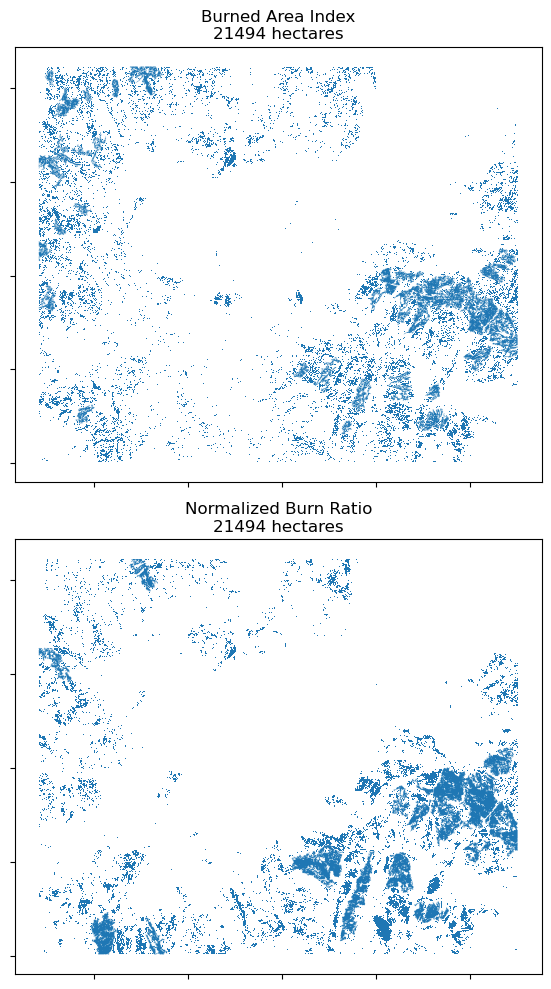

In [20]:
fig, ax = plt.subplots(figsize=(7.5,10), nrows=2, ncols=1)
bai_gdf.plot(ax=ax[0])
ax[0].set_title(f"Burned Area Index\n{bai_burned_hectares} hectares")
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])

nbr_gdf.plot(ax=ax[1])
ax[1].set_title(f"Normalized Burn Ratio\n{nbr_burned_hectares} hectares")
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
plt.tight_layout()

#### Export for GIS
Saving results for GIS environments:

In [ ]:
bai_gdf.to_file("bai_burned_area.geojson")
nbr_gdf.to_file("nbr_burned_area.geojson")

## Discussion
_**Extending the Analysis and Contextualizing Results**_

To enhance this analysis:

- **_Full Mosaic Processing_**: Apply the workflow to the entire mosaic to capture all areas affected by the Dixie Fire. This will provide a comprehensive assessment but will require more processing time.
- **_Experiment with Other Indices_**: Try [additional spectral indices](https://github.com/awesome-spectral-indices/awesome-spectral-indices) like the Char Soil Index (CSI) or Mid-Infrared Burn Index (MIRBI) to compare and validate results.
- **_Water Masking_**: Much of this area is covered in water, which regularly skews results when not properly masked out. 

### _Cleaning up:_

In [ ]:
os.remove("BAI_diff.tif")
os.remove("bai_burned_area.geojson")
os.remove("nbr_burned_area.geojson")